In [1]:
import functions as fct
import pandas as pd
import dynamics as dyn
import numpy as np
import dask
from cluster import new_launch_cluster
import graphics as gx

# parameter setting
nb_banks=50
path = "./results/parameter_space/test/"
initial_deposits_size = 40

# reg ratios
alpha_init=False  # initial cash (< 1/(1-gamma) - beta)
alpha=0.01
beta_init=0.5 # initial collateral  (< 1/(1-gamma) - alpha)
beta_reg=0.5
beta_star=0.5
gamma=0.03
gamma_init = 3*gamma
collateral_value=1.0

# initialisation of deposits size
initialization_method="pareto"
alpha_pareto=1.3

# shocks on deposits 
shocks_method="non-conservative"
shocks_law="normal-mean-reverting"
shocks_vol=0.01 # 0.05

# speed of learning
learning_speed = 0.5

# min trans size
min_repo_trans_size=1e-8  # 1e-8

# dynamics & ploting
nb_steps=int(20e3)
dump_period=int(5e3)
plot_period=int(5e3)
cp_option=True
heavy_plot=False

# LCR mgt
LCR_mgt_opt=True

# leverage mgt
end_repo_period=False # if int, periodic end repo / if false, leverage mgt
gamma_star = 1.5*gamma
check_leverage_opt = False # to avoid killing the run if one or several banks are below min leverage due to high shocks (there is not possibility of decrease balance sheet size if no interbank borrowings)

# money creation
loan_tenor=nb_steps # if int, money creation / if false. no new loans
loan_period=1
new_loans_vol = 0 # standard deviation around the mean creation of loans
new_loans_mean = 100e-2/250 # daily mean increase in loans expressed as a percentage of the intital loans (the other option would be a relative increase but it is unstable np.exp(np.log(1.01)/250)-1 = 4e-5)
beta_new = beta_reg # if number, new colat / if false, no new colat 
# gamma_new = gamma_star*(beta_reg+1)/(1+gamma_star*beta_reg) # if number, new own funds / if false, no new own funds. we need to also add beta reg to ensure LCR can be covered with additional cash (and we still match the solvency ratio despite this excess of stress) in the case of no payment shocks and no collateral creation
gamma_new = 1.7*gamma_star

# substitution of collateral
substitution = False

dic_default_value = {
    "nb_banks": nb_banks,
    "initial_deposits_size": initial_deposits_size,
    "alpha_init": alpha_init,
    "alpha": alpha,
    "beta_init": beta_init,
    "beta_reg": beta_reg,
    "beta_star": beta_star,
    "beta_new": beta_new,
    "gamma_init": gamma_init,
    "gamma": gamma,
    "gamma_star": gamma_star, 
    "gamma_new": gamma_new, 
    "collateral_value": collateral_value,
    "initialization_method": initialization_method,
    "alpha_pareto": alpha_pareto,
    "shocks_method": shocks_method,
    "shocks_law": shocks_law,
    "shocks_vol": shocks_vol,
    "LCR_mgt_opt": LCR_mgt_opt,
    "min_repo_trans_size": min_repo_trans_size,
    "loan_tenor": loan_tenor, # for money creation 
    "loan_period": loan_period,
    "new_loans_vol": new_loans_vol,
    "new_loans_mean": new_loans_mean,
    "end_repo_period": end_repo_period,
    "nb_steps": nb_steps,
    "path_results": f"{path}runs/",
    "dump_period": dump_period,
    "plot_period": plot_period,
    "cp_option": cp_option,
    "heavy_plot": heavy_plot,  # False to avoid the number of linux node to explode
    "substitution":substitution,
    "learning_speed":learning_speed,
    "check_leverage_opt":check_leverage_opt,
}

# special dictionary of parameters ranges 
list_dic_range_special = [
    # {"gamma_init": [k*gamma for k in np.arange(2,3,0.1)],
    # "gamma_new": [k*gamma for k in np.arange(2,3,0.1)],},
    # {"min_repo_trans_size": np.logspace(-15, 5, num=100)},
    {"gamma_init": np.arange(1, 2,0.01)*gamma_star},
    {"gamma_new": np.arange(1, 2,0.01)*gamma_star},
    {"learning_speed": np.arange(0.01, 1.01, 0.01)},
    {"nb_banks": np.arange(50, 5050,50)},
    {"shocks_vol": np.arange(0, 0.30, 0.003)},
]

# general dictionary of parameters ranges
list_dic_range_general = [
    {"nb_banks": np.arange(1, 3)},
    {"initial_deposits_size": np.logspace(-9, 3, num=50)},
    {"alpha_init": np.arange(0, 1, 0.1)},
    {"beta_init": np.arange(0, 1, 0.05)},
    {"beta_reg": np.arange(0, 1, 0.05)},
    {"alpha_pareto": np.logspace(0, 1, num=3)},
    {"shocks_vol": np.arange(0, 0.30, 0.003)},
    {"min_repo_trans_size": np.logspace(-16, 2, num=3)},
    {"gamma_star": np.arange(0, 10*gamma, 0.01)},
] 

# define the dictionary to be used for the ranges
list_dic_range = list_dic_range_special


In [7]:
np.arange(50, 5050,50)[-1]

5000

# run parameter space analysis

In [2]:
# initialize the path
# fct.delete_n_init_path(path)

# build list of the dic_args to be tested
list_dic_args = fct.build_args(dic_default_value, list_dic_range)

# open a cluster
client, cluster = new_launch_cluster(
    task_memory=19,
    job_walltime="48:00:00",
    max_cpu=len(list_dic_args),
)

# run with dask distributed
dld_obj = [
    dask.delayed(dyn.single_run)(**dic_args) for dic_args in list_dic_args
]
futures = client.compute(dld_obj)


Task exception was never retrieved
future: <Task finished name='Task-171' coro=<_wrap_awaitable() done, defined at /mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/asyncio/tasks.py:688> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: 1\nCommand:\nsbatch /opt/tmp/tmp/tmpdb58aq52.sh\nstdout:\n\nstderr:\nsbatch: error: Batch job submission failed: Socket timed out on send/recv operation\n\n')>
Traceback (most recent call last):
  File "/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/asyncio/tasks.py", line 695, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/distributed/deploy/spec.py", line 64, in _
    await self.start()
  File "/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/dask_jobqueue/core.py", line 411, in start
    out = await self._submit_job(fn)
  File "/mnt/live/user/vlecoz/conda_env/money_markets/lib/py

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.70.211.9:8787/status,
Dashboard: http://10.70.211.9:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.70.211.9:43996,Workers: 0
Dashboard: http://10.70.211.9:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
for i in np.arange(0.01, 1.01, 0.01)*gamma_init:
    print(i)

0.0009
0.0018
0.0026999999999999997
0.0036
0.0045
0.0054
0.006299999999999999
0.0072
0.0081
0.009
0.009899999999999999
0.010799999999999999
0.0117
0.0126
0.013500000000000002
0.0144
0.015300000000000001
0.016200000000000003
0.0171
0.018
0.0189
0.019799999999999998
0.0207
0.0216
0.0225
0.0234
0.024300000000000002
0.0252
0.0261
0.027
0.027899999999999998
0.0288
0.0297
0.030600000000000002
0.0315
0.032400000000000005
0.033299999999999996
0.0342
0.0351
0.036
0.0369
0.0378
0.0387
0.039599999999999996
0.0405
0.0414
0.042300000000000004
0.0432
0.0441
0.045
0.045899999999999996
0.0468
0.0477
0.048600000000000004
0.0495
0.0504
0.051300000000000005
0.0522
0.053099999999999994
0.054
0.0549
0.055799999999999995
0.0567
0.0576
0.058499999999999996
0.0594
0.0603
0.061200000000000004
0.0621
0.063
0.0639
0.0648
0.0657
0.06659999999999999
0.0675
0.0684
0.0693
0.0702
0.0711
0.072
0.0729
0.0738
0.0747
0.0756
0.0765
0.0774
0.0783
0.07919999999999999
0.0801
0.081
0.0819
0.0828
0.0837
0.08460000000000001
0.0

In [9]:
! squeue -u vlecoz -h -t pending,running -r -O "state" | uniq -c

    331 RUNNING             


In [10]:
for i, future in enumerate(futures):
    if future.status == "finished":
        print(i, future.result())

0 None
1 None
2 None
3 None
4 None
5 None
6 None
7 None
8 None
9 None
10 None
11 None
12 None
13 None
14 None
15 None
16 None
17 None
18 None
19 None
20 None
21 None
22 None
23 None
24 None
25 None
26 None
27 None
28 None
29 None
30 None
31 None
32 None
33 None
34 None
35 None
36 None
37 None
38 None
39 None
40 None
41 None
42 None
43 None
44 None
45 None
46 None
47 None
48 None
49 None
50 None
51 None
52 None
53 None
54 None
55 None
56 None
57 None
58 None
59 None
60 None
61 None
62 None
63 None
65 None
66 None
67 None
68 None
69 None
70 None
71 None
72 None
73 None
74 None
75 None
76 None
77 None
78 None
79 None
80 None
81 None
82 None
83 None
84 None
85 None
86 ***ERROR***: leverage ratio not above its regulatory level for one or several banks. Plot and stop simulation.
87 None
88 None
89 None
90 None
91 None
92 None
93 None
94 None
95 None
96 None
97 None
98 None
99 None
100 None
101 None
102 None
103 None
104 None
105 None
106 None
107 None
108 None
109 None
110 None
111 None
112 

In [6]:
client.shutdown()

In [ ]:
dyn.single_run(*dic_default_value.values())

# collect results

In [11]:
# collect results into df_network_sensitivity
df_network_sensitivity = fct.get_df_network_sensitivity(dic_default_value["path_results"])

100%|██████████| 5/5 [03:01<00:00, 36.36s/it]


# plot results

In [ ]:
import parameters as par
par.df_plt.loc["gamma_new", "convertion"]

  0%|          | 0/18 [00:01<?, ?it/s]


KeyError: 'learning_speed'

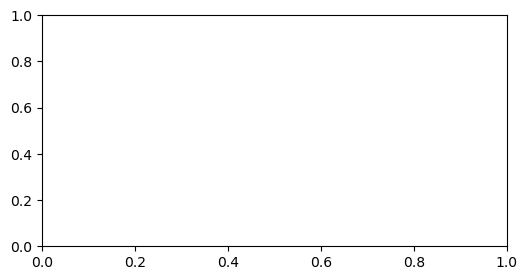

In [12]:
# plot the sensitivity
df_network_sensitivity = pd.read_csv(f"{dic_default_value['path_results']}df_network_sensitivity.csv", index_col=(0,1))
gx.plot_all_sensitivities(df_network_sensitivity,path=path)